<a href="https://colab.research.google.com/github/youssefdarwish37/Image-Segmentation/blob/main/image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np 
import pandas as pd 
import sklearn as sk
import networkx as nx 
from sklearn.cluster import KMeans
from google.colab import drive
import matplotlib.pyplot as plt
from matplotlib import image
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import contingency_matrix
from sklearn.cluster import SpectralClustering
from cv2 import resize
import h5py
import scipy.io
import os 
import cv2
import glob 
import matplotlib.gridspec as gridspec
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# ***REMOVE WARNINGS***

In [ ]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

import warnings
warnings.filterwarnings("ignore")

# **Exploring Data**

In [ ]:
s = []
s1 = []
train_data = []
train_groundTruth = []

normalized=[]
files = []
for dirname, dirnames, filenames in os.walk('/content/gdrive/MyDrive/data/images/test',topdown = True):
    # print path to all subdirectories first.
    for subdirname in dirnames:
        files.append(os.path.join(dirname, subdirname))

    # print path to all filenames.
    for filename in filenames:
        files.append(os.path.join(dirname, filename))
files= sorted(files)
filesmat = []
for dirname, dirnames, filenames in os.walk('/content/gdrive/MyDrive/data/groundTruth/test',topdown = True):
    # print path to all subdirectories first.
    for subdirname in dirnames:
        filesmat.append(os.path.join(dirname, subdirname))

    # print path to all filenames.
    for filename in filenames:
        filesmat.append(os.path.join(dirname, filename))
filesmat = sorted(filesmat)        

for i in range (50):
  
  s.append(files[i])

  #comment mohem
  im = image.imread(s[i])
  train_data.append(im)
  # plt.imshow(im)
  # plt.show()
  # plt.show()

  s1.append(filesmat[i])
  #comment mohem
  f = scipy.io.loadmat(s1[i])
  x = f["groundTruth"]
  train_groundTruth.append(x)
  #for k in x:
  #  for j in k:
  #    x = j["Segmentation"]
  #     y = j["Boundaries"]
  #    plt.matshow(x[0][0])
  #     plt.matshow(y[0][0])


# **K-Means**

In [ ]:
def KMean(k , image , d = 3):
  flattened_image=image.reshape((-1, d))
  clusters = np.zeros(k)
  centroids = []
  randoms = np.random.randint(low = 0, high = flattened_image.shape[0], size = k)

  # random
  for i in range(k):
    centroids.append(flattened_image[randoms[i]])

  # First k points
  # for i in range(k):
  #   centroids.append(flattened_image[i])
  labels = np.zeros(np.asarray(centroids).shape)
  A=np.zeros((flattened_image.shape[0],np.asarray(centroids).shape[0]))
  for i in range(100):
    for k in range(len(centroids)):
      A[:,k]=np.linalg.norm(flattened_image-centroids[k],axis=1)
    labels=np.argmin(A,axis=1)
    new_centroids=np.array([flattened_image[labels==i].mean(axis=0) for i in range(k) ])
    if np.array_equal(centroids ,new_centroids):
      break
  return centroids,labels

## **Visualize**

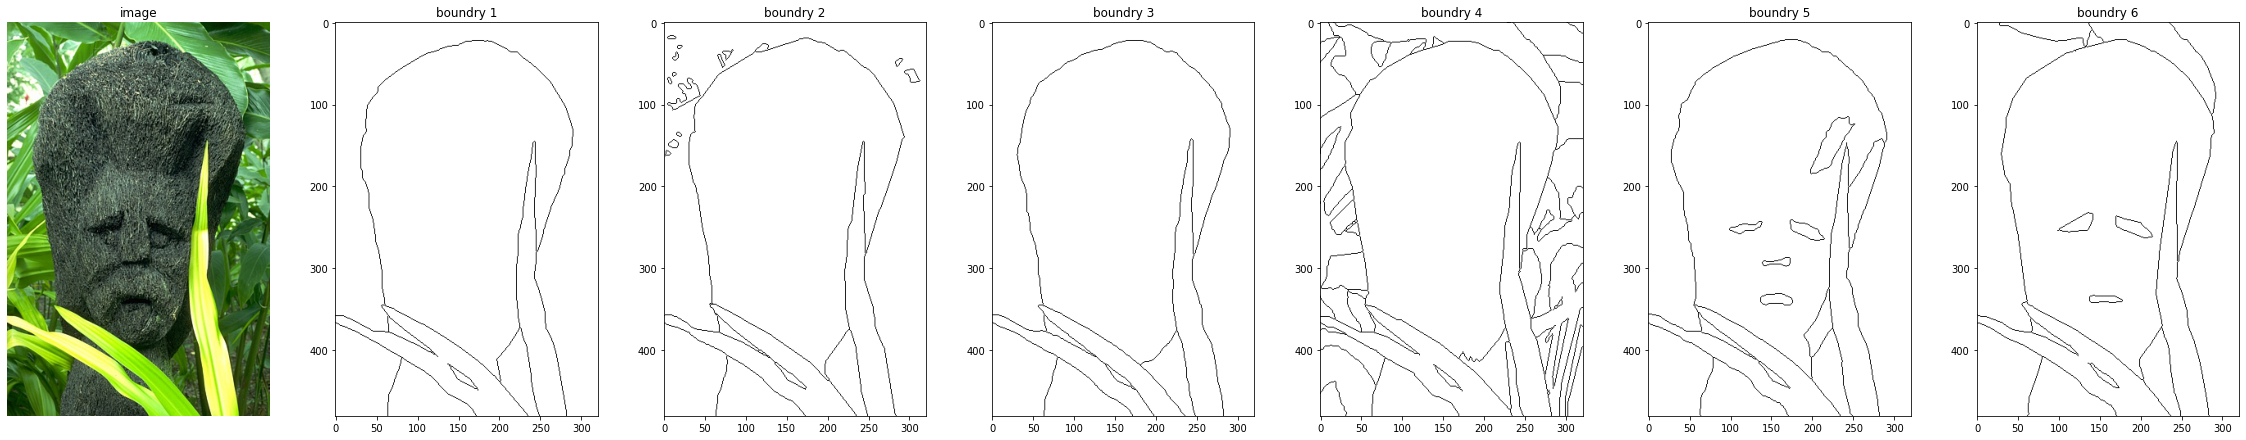

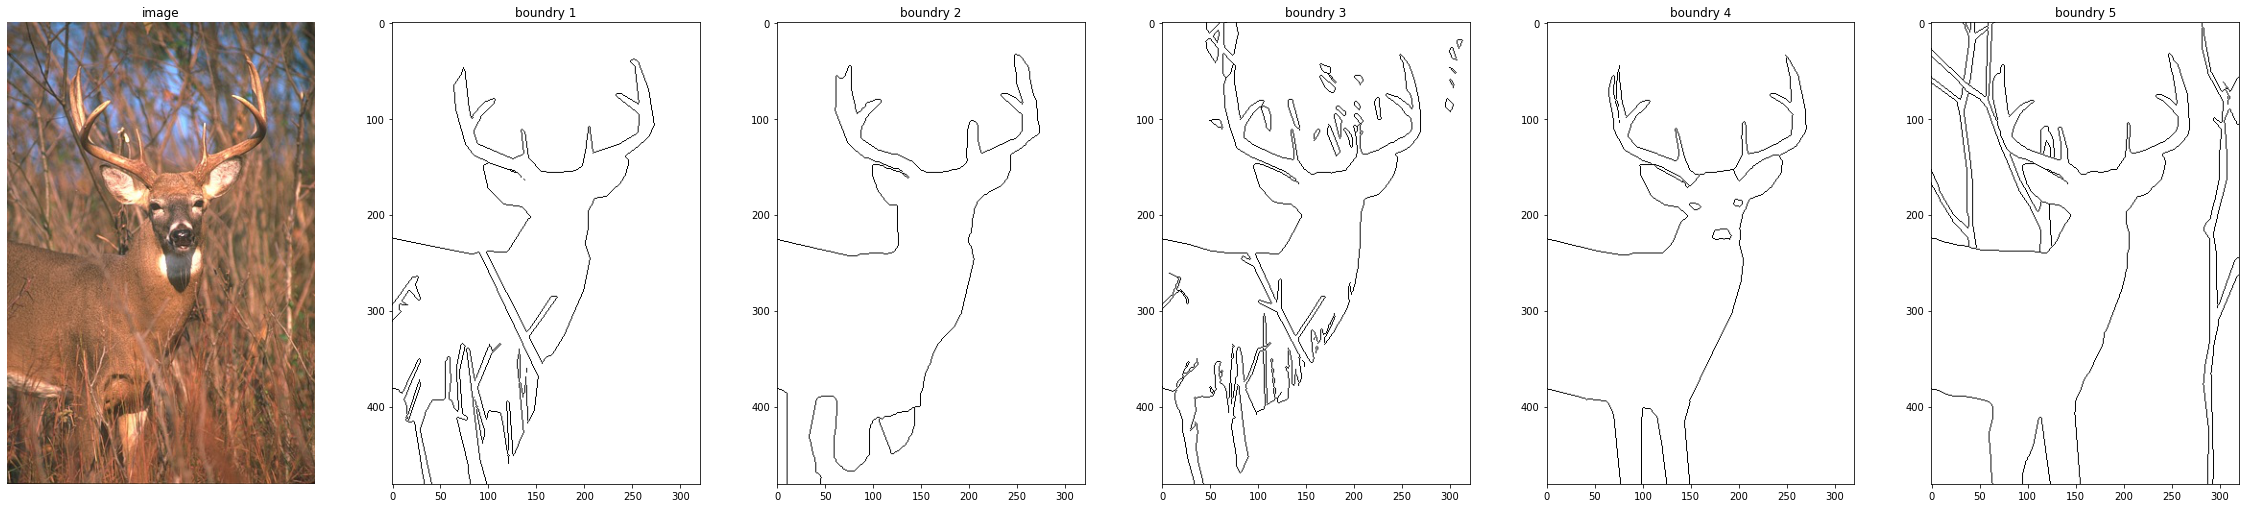

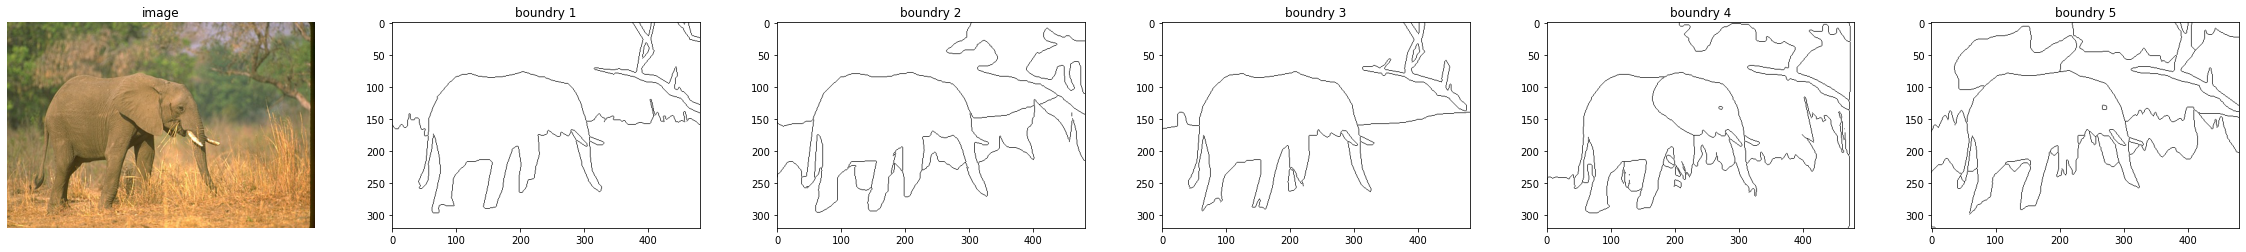

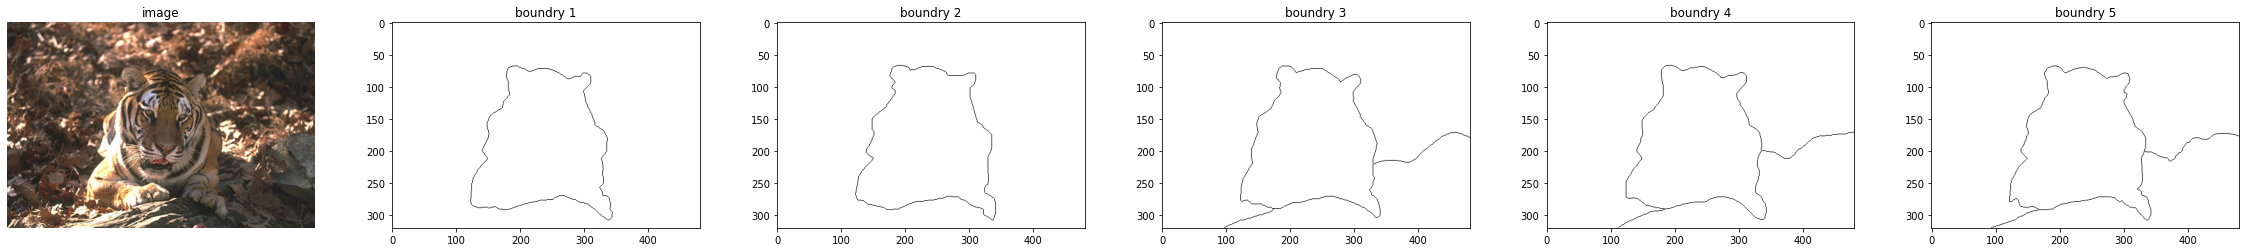

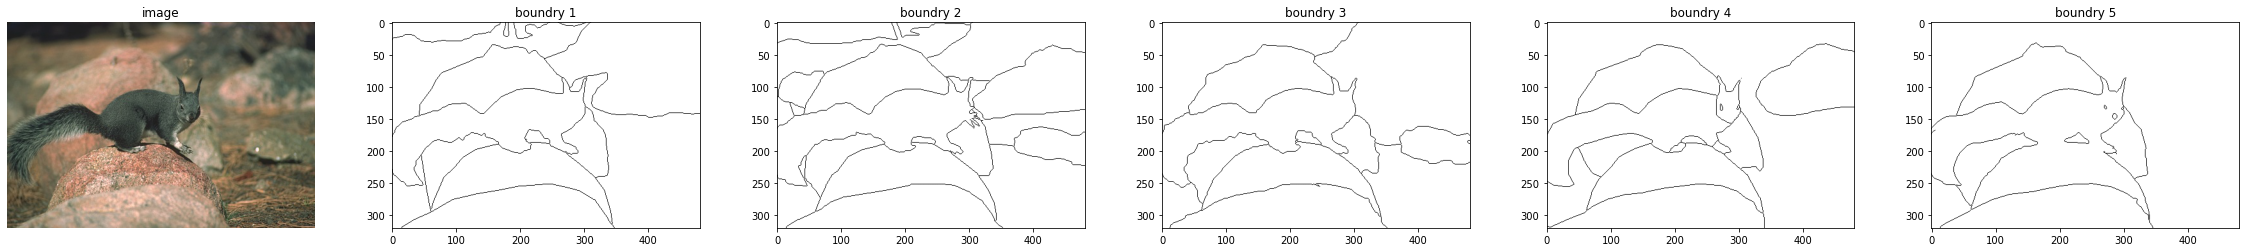

In [ ]:
def visualize(i):
  image = train_data[i]
  f = scipy.io.loadmat(s1[i])
  x = f["groundTruth"]
  c=0
  fig = plt.figure(figsize=(40, 40))
  gs1 = gridspec.GridSpec(1, len(x[0])+1)
  gs1.update(wspace=0.25, hspace=0.15)
  ax1 = plt.subplot(gs1[c])
  ax1.imshow(image)
  ax1.set_title("image")
  c+=1
  ax1.axis('off')
  for k in x:
    for j in k:
      # y= x[0][i]
      # y = j["groundTruth"]
      # y = j["Boundaries"]
      #Show Boundaries
      ax2 = plt.subplot(gs1[c])
      ax2.set_title("boundry "+str(c))
      c+=1
      ax2.imshow(j[0][0]['Boundaries'],cmap = "binary")
      
    plt.show()
      #Show Segmentations
      # plt.imshow(j[0][0][0])
      # plt.show()
images = [5,10,15,20,30]
for pic in images: 
  visualize(pic)

## **F_measure** 

In [ ]:
def f_measure(y_true,y_pred):
  #precision = precision_score(y_true,y_pred, average='weighted',labels=np.unique(y_pred),zero_division=1)
  #recall = recall_score(y_true,y_pred, average='weighted',labels=np.unique(y_pred),zero_division=1)
  #f = (2 * precision * recall) / (precision + recall)
  contingency_mat = contingency_matrix(y_true, y_pred)
  maxpos=contingency_mat.argmax(axis=1)
  fi = 0
  f_total = 0
  for i in range(contingency_mat.shape[0]):
        ni = np.sum(contingency_mat[i]) 
        pre = contingency_mat.max(axis=1)[i]#purity/percision calculcation 
        r1 = contingency_mat[:,maxpos[i]]#recall_calculation
        r = np.sum(r1)#recall calculation
        fi = fi + 2 * pre/(ni+r)
  f_total = fi/contingency_mat.shape[1]     
  return f_total
  

## **Conditional** **entropy**

In [ ]:
def conditional_entropy(y_true,y_pred):
  contingency_mat = contingency_matrix(y_true,y_pred)
  sum_c = np.sum(contingency_mat,axis =1)
  sum_total = np.sum(sum_c)
  for n in range(contingency_mat.shape[0]):
    for m in range(contingency_mat.shape[1]):
      if(contingency_mat[n][m] == 0):
        contingency_mat[n][m]=1 #as log0 -->error
  HC = np.zeros((contingency_mat.shape[0]))
  for t in range(contingency_mat.shape[0]):
    ni =  np.sum(contingency_mat[t])
    HC[t] = (sum_c[t]*np.sum(-contingency_mat[t]*np.log10(contingency_mat[t]/ni))/ni)
          
  c_entropy = np.sum(HC)/sum_total
  return c_entropy


## **Measures**

In [ ]:
def measures(image_no):
  K = [3,5,7,9,11]
  image = scipy.io.loadmat(s1[image_no])
  x = image["groundTruth"]
  f_avg_list = []
  c_avg_list = []
  for f in K:
    centroids , labels = KMean(f,train_data[image_no]) 
    centers = np.uint8(centroids)
    labels = labels.flatten()
    labels = labels + 1
    segmented_image = labels.reshape(train_data[image_no].shape[0] , train_data[image_no].shape[1] )

    u_labels = np.unique(labels)
    f_list = []
    conditional_list = []
    f_avg = 0
    c_avg = 0
    
    for k in x:
      for j in k:
        f_list.append(f_measure(j[0][0][0].flatten(),segmented_image.flatten()))
        conditional_list.append(conditional_entropy(j[0][0][0].flatten(),segmented_image.flatten()))

    f_avg = sum(f_list)/len(f_list)
    c_avg = sum(conditional_list)/len(conditional_list)
    f_avg_list.append(f_avg)
    c_avg_list.append(c_avg)
    
  return f_avg_list , c_avg_list
  
total_list_fmeasures = []
total_list_conditional = []
for i in range(50):
  x , y = measures(i)
  total_list_fmeasures.append(x)
  total_list_conditional.append(y)
# print(total_list_fmeasures)
# print(total_list_conditional)




In [ ]:
# import module
from tabulate import tabulate
 

# create header
head = ["K = 3", "K = 5" , "K = 7" , "K = 9", "K = 11"]
total = np.hstack([total_list_fmeasures])
s=np.hstack([total_list_conditional])
# display table
print(tabulate(total, headers=head, tablefmt="fancy_grid")+"\n"+tabulate(s, headers=head, tablefmt="fancy_grid"))


╒══════════╤══════════╤══════════╤═══════════╤═══════════╕
│    K = 3 │    K = 5 │    K = 7 │     K = 9 │    K = 11 │
╞══════════╪══════════╪══════════╪═══════════╪═══════════╡
│ 0.778379 │ 0.44492  │ 0.363988 │ 0.301152  │ 0.240659  │
├──────────┼──────────┼──────────┼───────────┼───────────┤
│ 0.647934 │ 0.469447 │ 0.245405 │ 0.228845  │ 0.179228  │
├──────────┼──────────┼──────────┼───────────┼───────────┤
│ 0.52102  │ 0.335123 │ 0.224791 │ 0.212575  │ 0.148193  │
├──────────┼──────────┼──────────┼───────────┼───────────┤
│ 0.61106  │ 0.348051 │ 0.292434 │ 0.219069  │ 0.199557  │
├──────────┼──────────┼──────────┼───────────┼───────────┤
│ 0.594837 │ 0.466869 │ 0.262032 │ 0.24364   │ 0.159983  │
├──────────┼──────────┼──────────┼───────────┼───────────┤
│ 0.744622 │ 0.352635 │ 0.390838 │ 0.205662  │ 0.240549  │
├──────────┼──────────┼──────────┼───────────┼───────────┤
│ 0.571665 │ 0.298686 │ 0.241411 │ 0.170231  │ 0.128981  │
├──────────┼──────────┼──────────┼───────────┼──────────

# **Big Picture**

In [ ]:
def KmeansVsGroundtruth():
    print("------------------------------------------------------------------------------------------------------KMEANS-----------------------------------------------------------------------------------------------------------------")
    images = [5,10,15,20,30]
    for pic in images:
        f = scipy.io.loadmat(s1[pic])
        x = f["groundTruth"]
        
        c=0
        fig = plt.figure(figsize=(40, 40))
        gs1 = gridspec.GridSpec(1, len(x[0])+1)
        gs1.update(wspace=0.025, hspace=0.05)
        #using kmeans when k = 5
        
        centroids , labels = KMean(5,train_data[pic])
        labels = labels.flatten()
        labels = labels + 1
        segmented_image = labels.reshape(train_data[pic].shape[0] , train_data[pic].shape[1] )
        for k in x:
          #plotting our segmmented image
          ax1 = plt.subplot(gs1[c])
          ax1.imshow(segmented_image)
          c+=1
          ax1.axis('off')
          ax1.set_title("kmeans segmented")
          for j in k:
              #plotting its segmentations 
              ax2 = plt.subplot(gs1[c])
              ax2.set_title("ground truth "+str(c))
              c+=1
              ax2.imshow(j[0][0]['Segmentation'])
              ax2.axis('off')
              
              f_measures=(f_measure(j[0][0]['Segmentation'].flatten(),segmented_image.flatten()))
              conditional_entropies=(conditional_entropy(j[0][0]['Segmentation'].flatten(),segmented_image.flatten()))
              j="f measure= "+str(f_measures)+"\n"+"entropy="+str(conditional_entropies)
              ax2.text(0.5,-0.1,j , size=12, ha="center", 
              transform=ax2.transAxes)
              #print fscore and entropy with segmented image
          plt.show()
          print("\n")


## **Normalized Cut**

In [ ]:
def spectral_Clustering(sim_matrix,k):
    A = sim_matrix
    D = np.diag(A.sum(axis=1))
    L = D - A
    D_inv = np.linalg.inv(D)
    B = np.dot(D_inv, L)
    eigenvalues, eigenvectors = np.linalg.eig(B)

    eigenvectors = eigenvectors[:,np.argsort(eigenvalues)]
    eigenvalues = eigenvalues[np.argsort(eigenvalues)]
    eigenvalues = eigenvalues.real
    eigenvectors = eigenvectors.real

    eigenvectors = eigenvectors.T
    U = eigenvectors[:k].T

    Y = np.zeros(U.shape)
    for i in range(0,U.shape[0]):
      norm=np.linalg.norm(U[i])
      Y[i]=U[i]/norm
    centeroids = KMeans(n_clusters=5 , random_state= 0).fit(Y)
    labels = centeroids.labels_.flatten()
    labels = labels + 1
    

    return labels

In [ ]:
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csr_matrix

def normailized_cutVsGroundTruth():
    print("--------------------------------------------------------------------------------------------------NORMALIZED ---------------------------------------------------------------------------------------------------------------")
    images = [5,10,15,20,30]
    for pic in images:
        #loading picture by its number 
        f = scipy.io.loadmat(s1[pic])
        x = f["groundTruth"]
        
        c=0
        fig = plt.figure(figsize=(40, 40))
        gs1 = gridspec.GridSpec(1, len(x[0])+1)
        gs1.update(wspace=0.025, hspace=0.05)

        #changing size of all slected images to cluster using normalized cuts
        image=train_data[pic]
        image = resize(image, (100, 100))
        
        A = kneighbors_graph(image.reshape(-1,3), 5, mode='connectivity', include_self=False)
        A=csr_matrix.toarray(A)
        
        labels=spectral_Clustering(A,5)
        segmented_image = labels.reshape(100 ,100)
        
        normalized.append(segmented_image)

        #built in function
        #s = SpectralClustering(n_clusters=5, 
                         #affinity='nearest_neighbors', n_neighbors=5,random_state=0).fit_predict(A)
        #s=s.reshape(image.shape[0], image.shape[1])
        
        for k in x:
          #plotting our segmmented image
          ax1 = plt.subplot(gs1[c])
          ax1.set_title("normalized segmented")
          ax1.imshow(segmented_image)
          c+=1
          ax1.axis('off')
          for j in k:
              #plotting its segmentations after resizing
              g_t=j[0][0]['Segmentation']
              g_t=resize(g_t, (100,100))
              ax2 = plt.subplot(gs1[c])
              ax2.set_title("ground truth "+str(c))
              c+=1
              plt.imshow(g_t)
              ax2.axis('off')
              f_measures=(f_measure(g_t.flatten(),segmented_image.flatten()))
              conditional_entropies=(conditional_entropy(g_t.flatten(),segmented_image.flatten()))
              j="f measure= "+str(f_measures)+"\n"+"entropy="+str(conditional_entropies)
              ax2.text(0.5,-0.1,j , size=12, ha="center", 
              transform=ax2.transAxes)

        plt.show()
        print("\n")

## **Normalized Vs Kmeans**

In [ ]:
def normalizedvsKmeans():
    print("------------------------------------------------------------------------------------------NORMALIZED VS KMEANS-------------------------------------------------------------------------------------------------------------")
    images = [5,10,15,20,30]
    c=0  
    for pic in images:   
       
        fig = plt.figure(figsize=(15, 20))
        gs1 = gridspec.GridSpec(1, 2)
        gs1.update(wspace=0.025, hspace=0.05)
        #changing size of all slected images to cluster using normalized cuts
        image=train_data[pic]
        image = resize(image, (100, 100))
        #plotting normalized
        ax1 = plt.subplot(gs1[0])
        ax1.imshow(normalized[c])
        ax1.axis('off')
        ax1.set_title("normalized segmented")
        #using kmeans when k = 5
        centroids , labels = KMean(5,image)
        labels = labels.flatten()
        labels = labels + 1
        segmented_image = labels.reshape(100 ,100 )

        #plotting kmeans
        ax2 = plt.subplot(gs1[1])
        ax2.imshow(segmented_image)
        ax2.axis('off')
        ax2.set_title("kmeans segmented")
        c+=1
        plt.show()
        print("\n")
       

------------------------------------------------------------------------------------------------------KMEANS-----------------------------------------------------------------------------------------------------------------


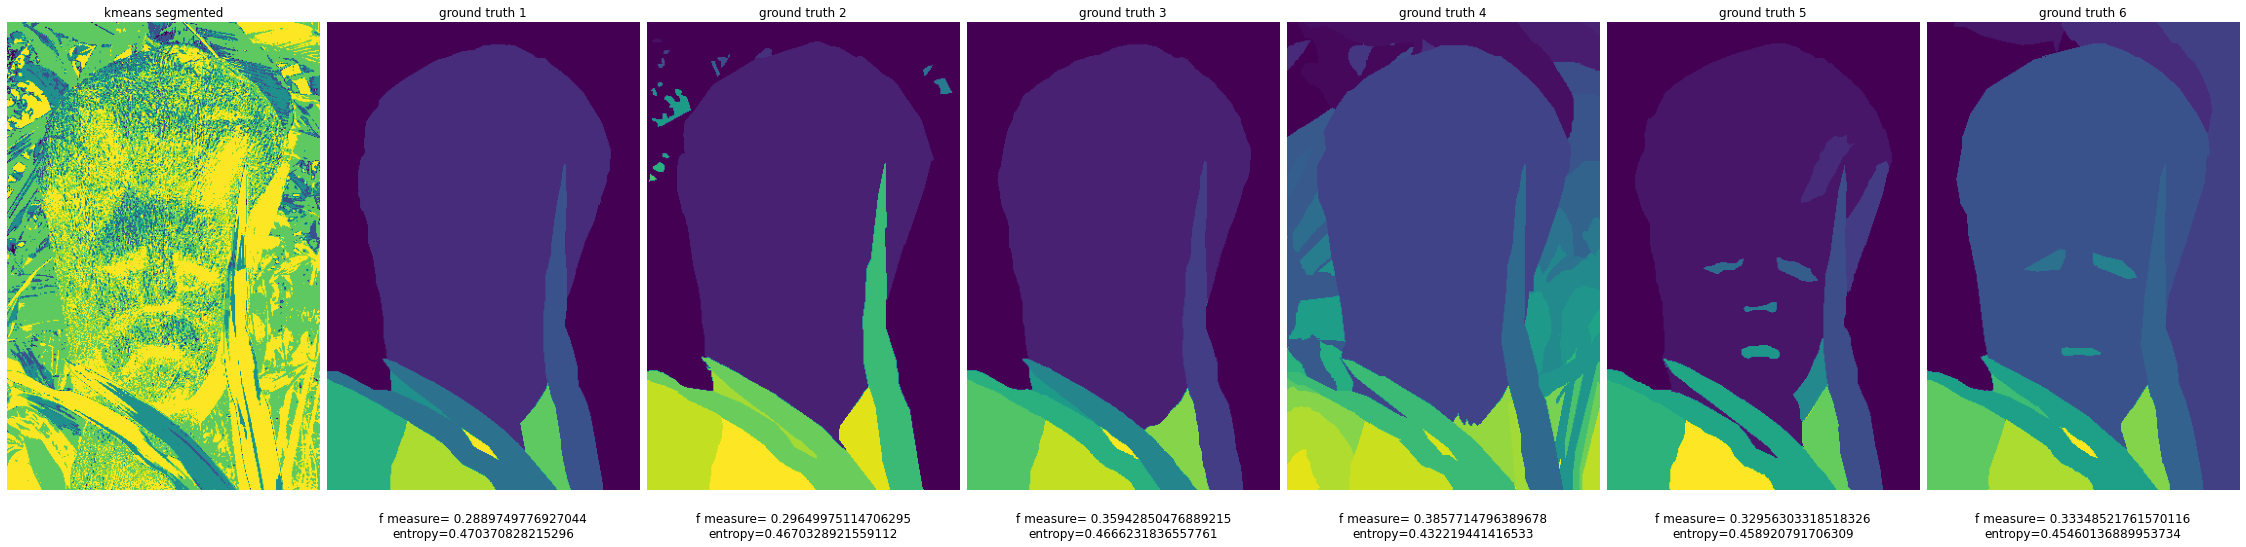

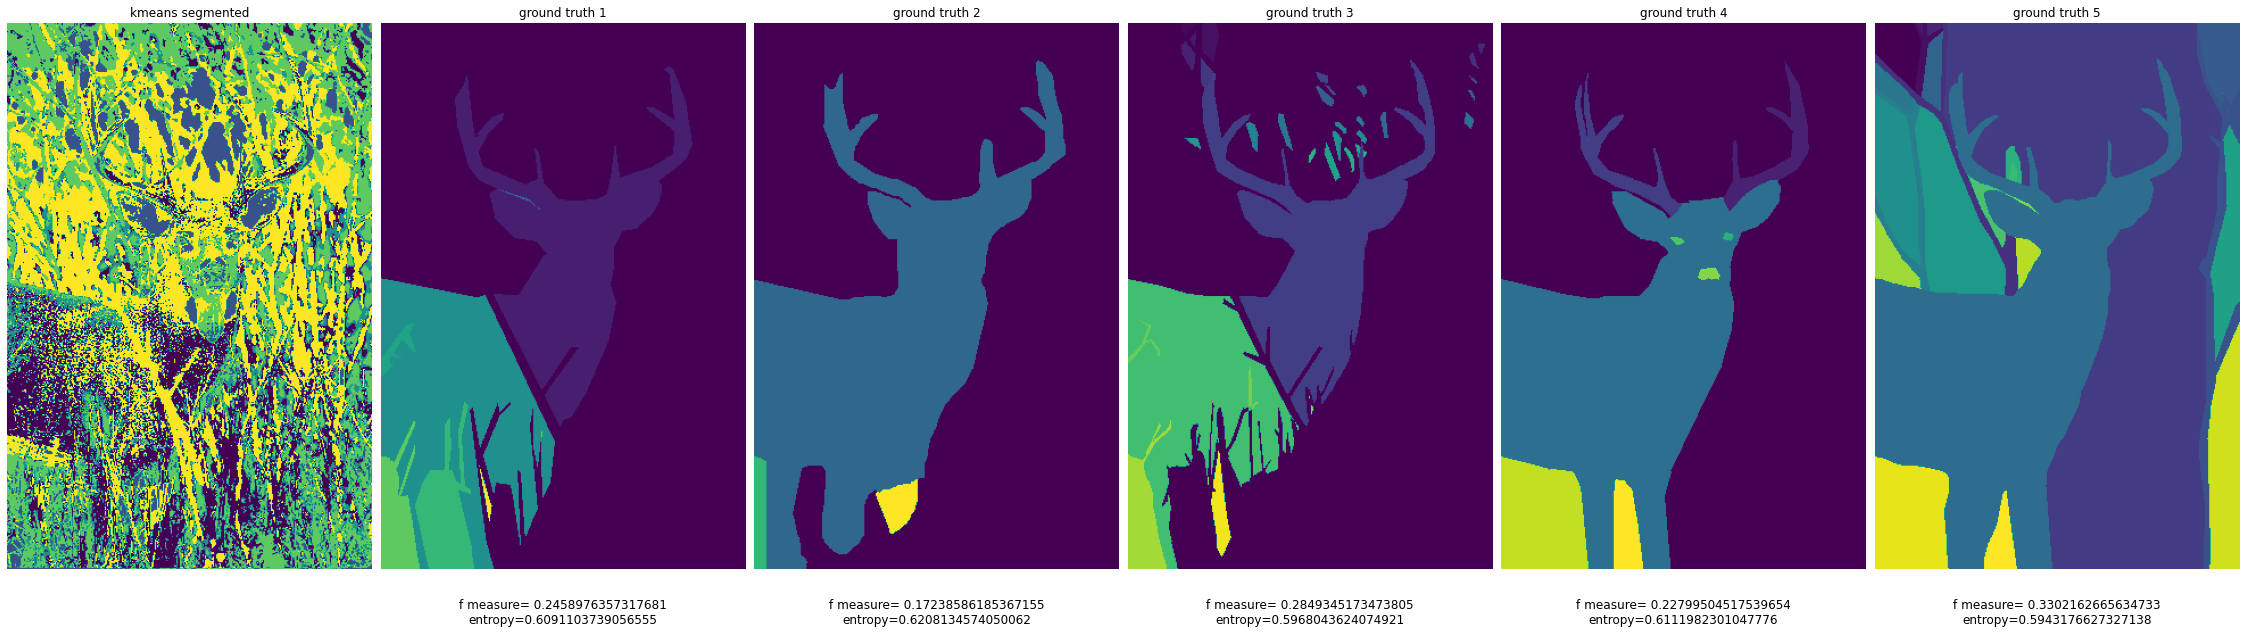

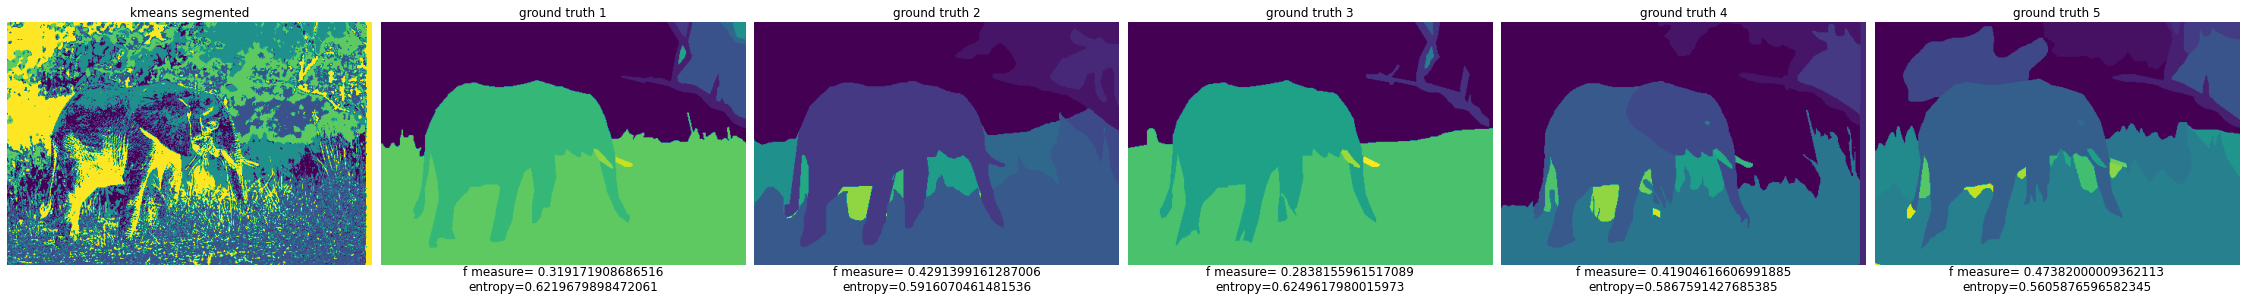

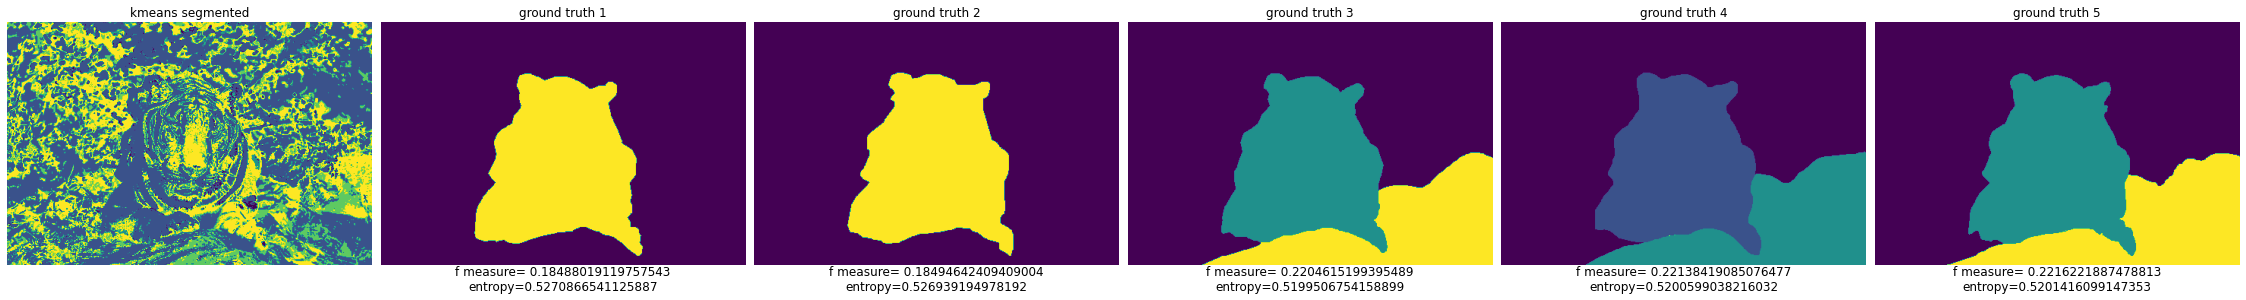

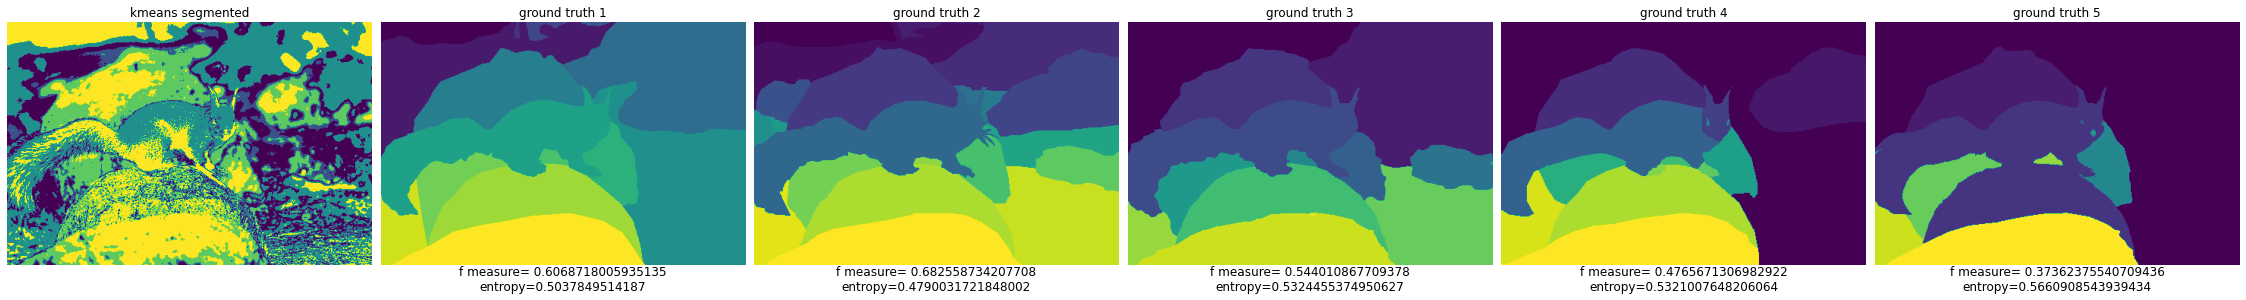



--------------------------------------------------------------------------------------------------NORMALIZED ---------------------------------------------------------------------------------------------------------------


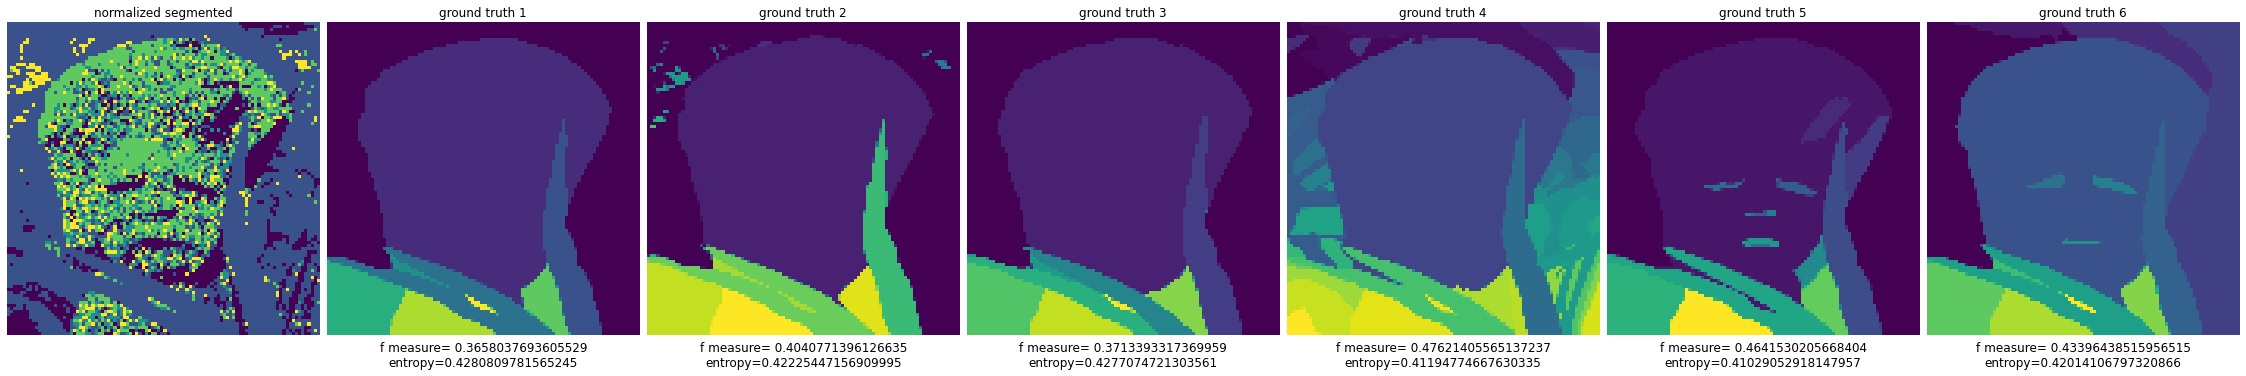

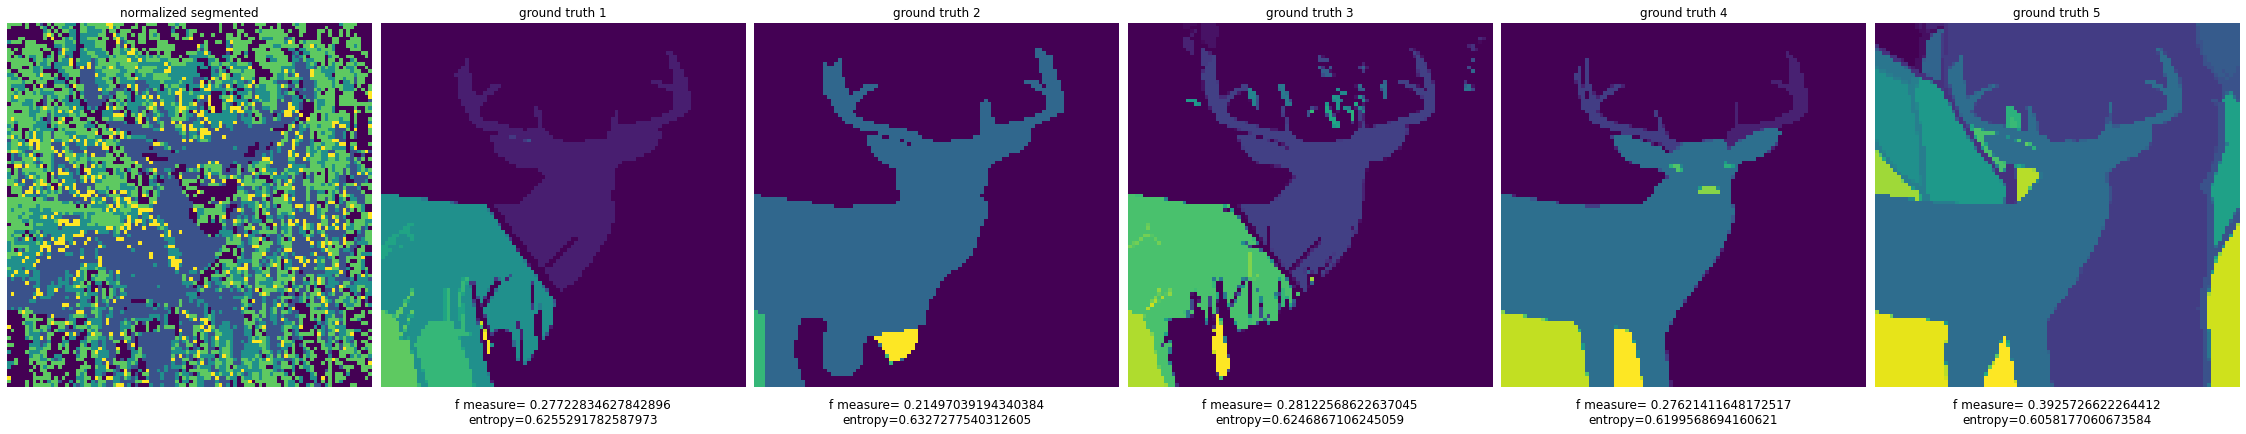

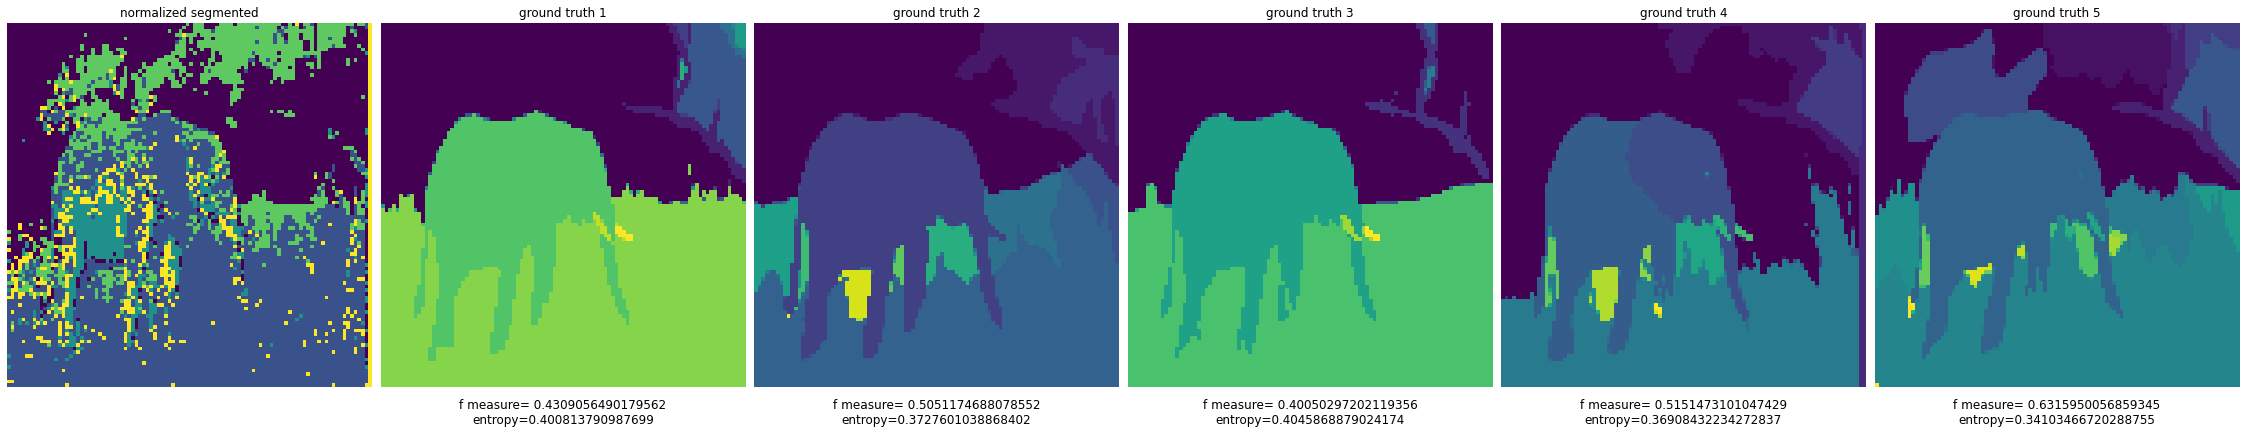

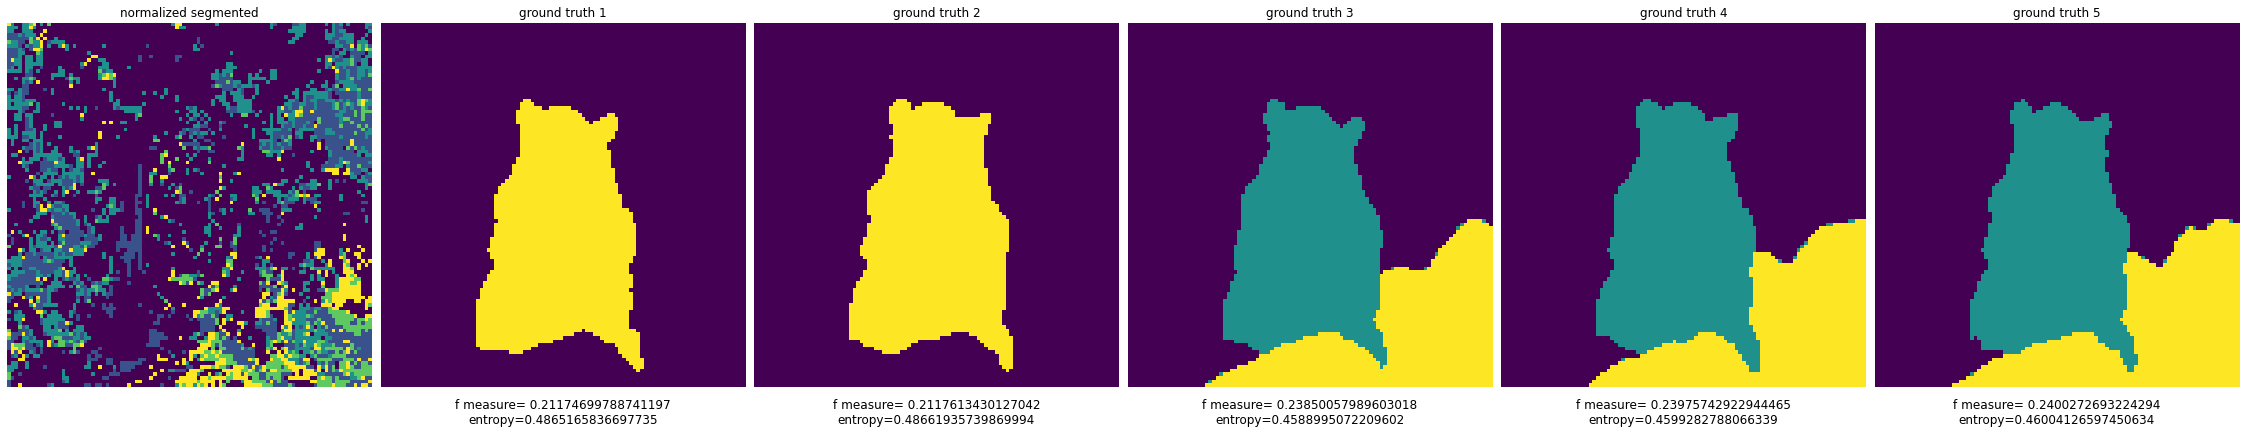

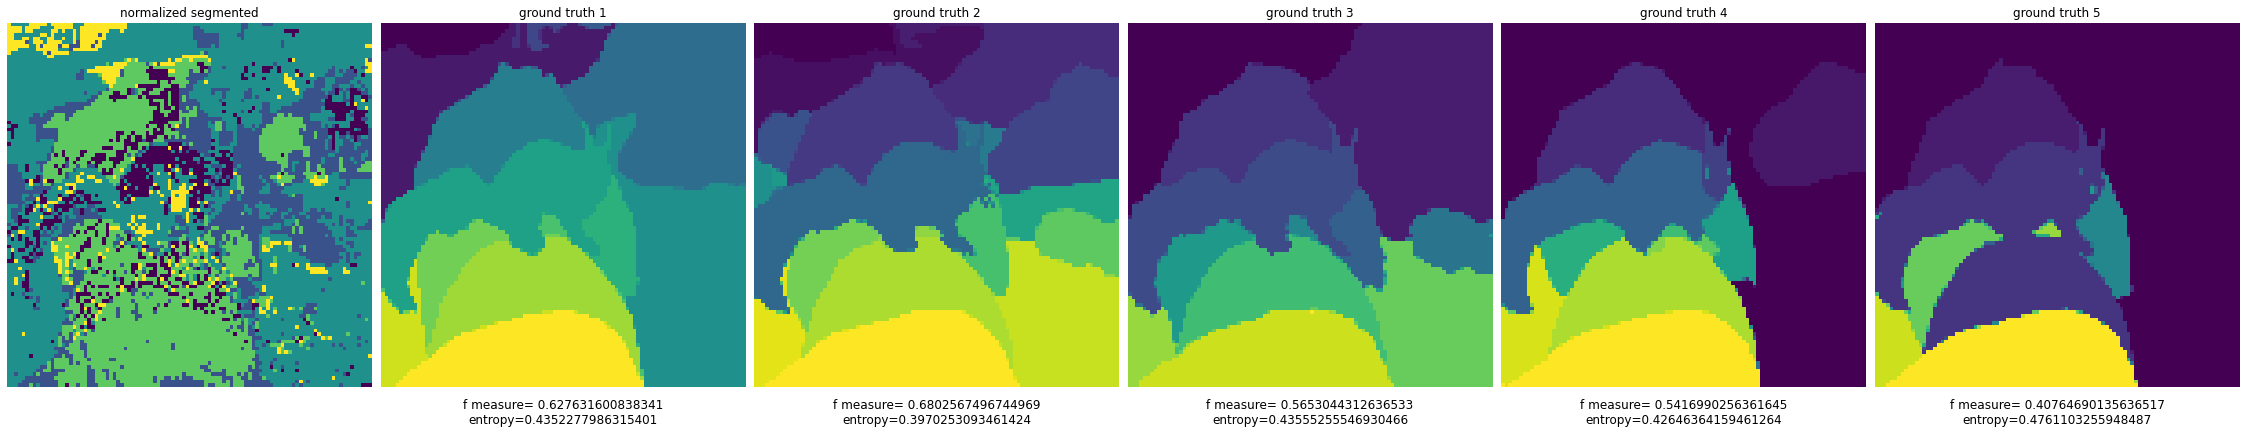



------------------------------------------------------------------------------------------NORMALIZED VS KMEANS-------------------------------------------------------------------------------------------------------------


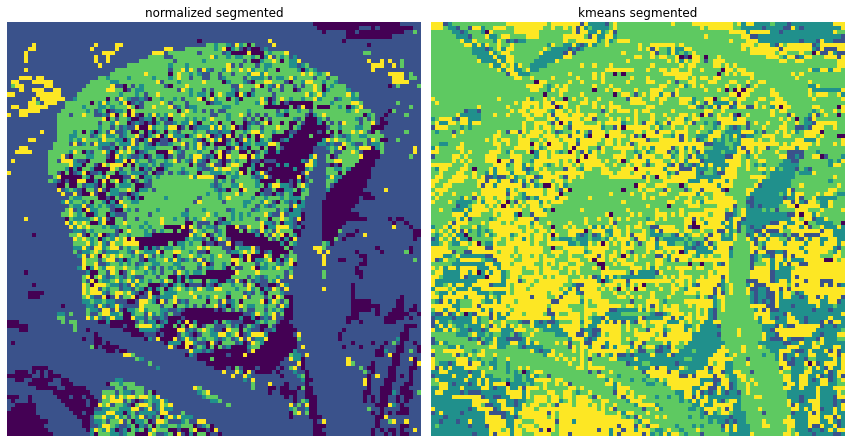

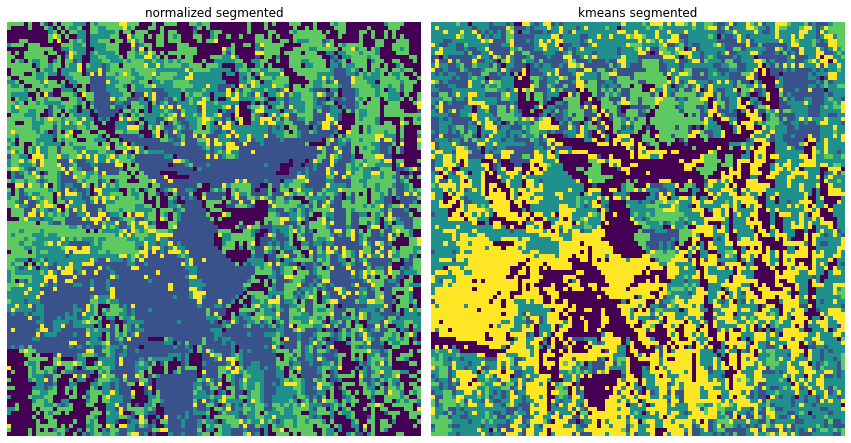

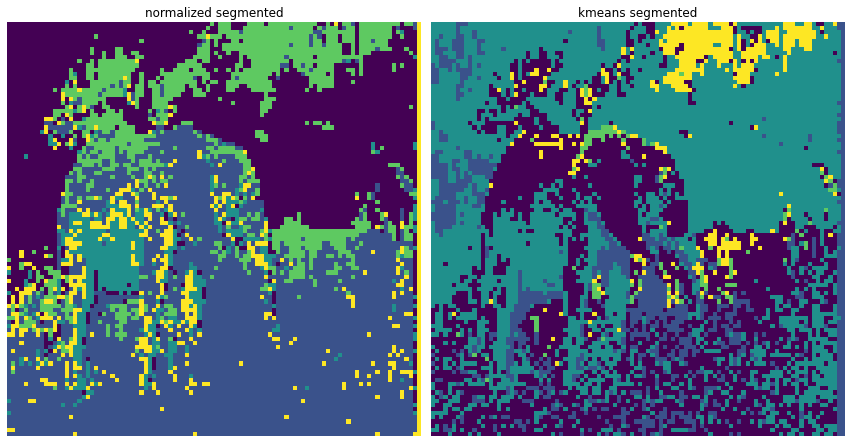

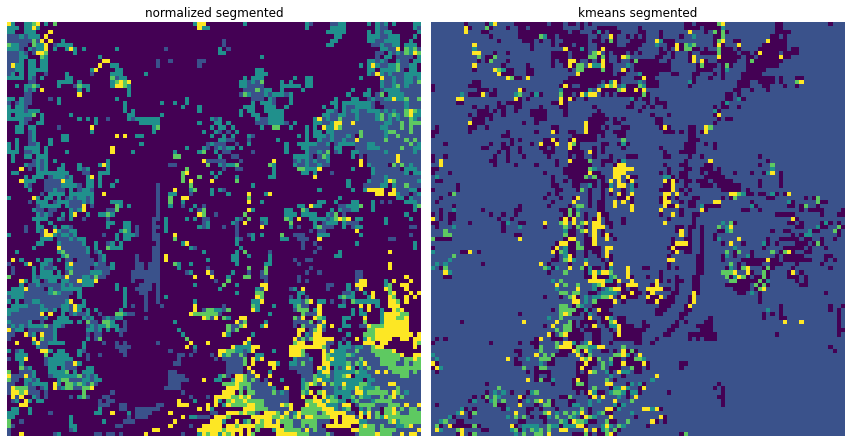

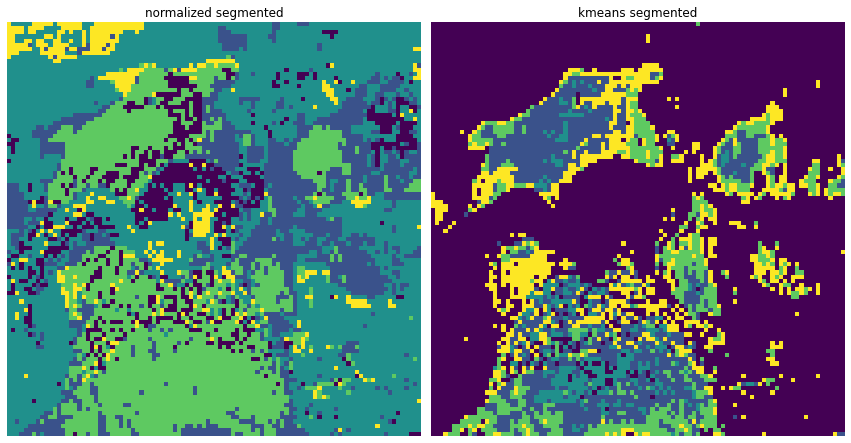

In [ ]:
KmeansVsGroundtruth()
normailized_cutVsGroundTruth()
normalizedvsKmeans()

# **Extra**

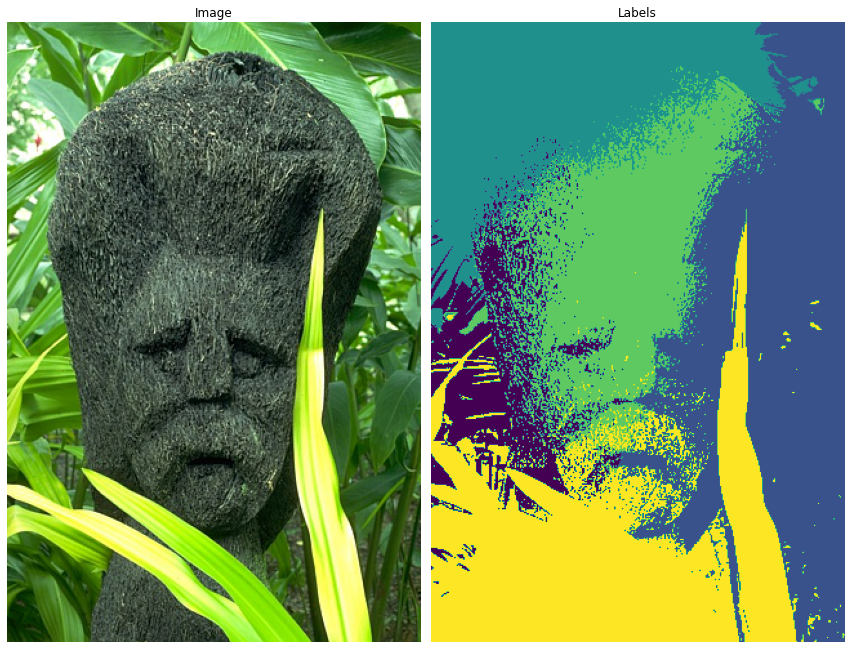

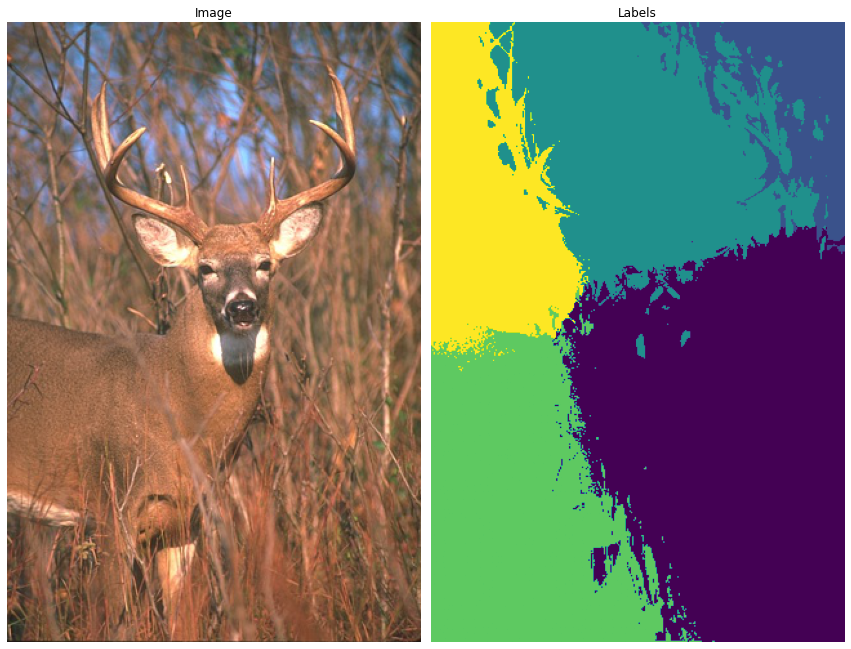

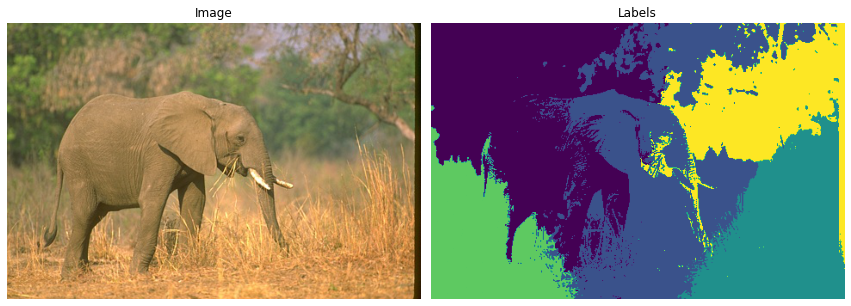

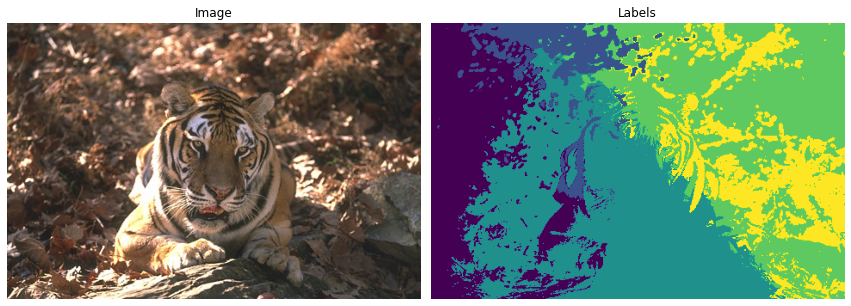

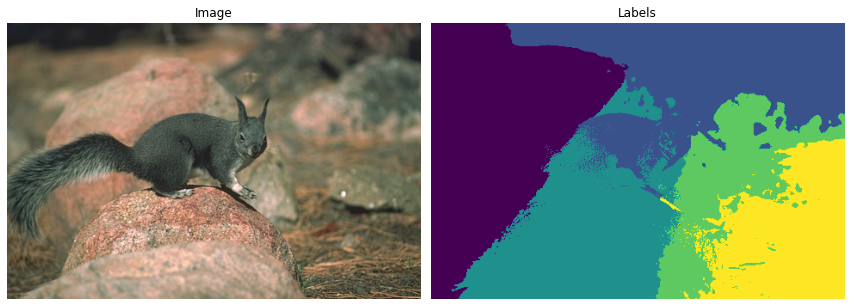

In [ ]:
N = [5,10,15,20,30]
for image_no in N:
  image = train_data[image_no]
  fig = plt.figure(figsize=(15, 20))
  gs1 = gridspec.GridSpec(1, 2)
  gs1.update(wspace=0.025, hspace=0.05)
  ax1 = plt.subplot(gs1[0])
  ax1.imshow(image)
  ax1.axis('off')
  ax1.set_title("Image")
  spatial_layout = []
  for x in range(image.shape[0]):
    for y in range(image.shape[1]):
      spatial_layout.append([x , y])
  spatial_layout = np.array(spatial_layout)
  spatial_layout = spatial_layout.reshape(image.shape[0] , image.shape[1] ,2)
  spatial_image = np.dstack((image,spatial_layout))
  centers , labels = KMean(5 , spatial_image,5)
  labels = labels.reshape(image.shape[0], image.shape[1])
  ax2 = plt.subplot(gs1[1])
  ax2.imshow(labels)
  ax2.axis('off')
  # f_measures=(f_measure(g_t.flatten(),s.flatten()))
  # conditional_entropies=(conditional_entropy(g_t.flatten(),s.flatten()))
  # j="f measure= "+str(f_measures)+"\n"+"entropy="+str(conditional_entropies)
  # ax2.text(0.5,-0.1,j , size=12, ha="center", 
  # transform=ax2.transAxes)
  ax2.set_title("Labels")
  plt.imshow(labels)
  plt.show()
